Version 1.0.0

# Introduction

In this programming assignment we will illustrate a very severe data leakage, that can often be found in competitions, where the pairs of object should be scored, e.g. predict $1$ if two objects belong to the same class and $0$ otherwise. 

The data in this assignment is taken from a real competition, and the funniest thing is that *we will not use training set at all* and achieve almost 100% accuracy score! We will just exploit the leakage.

Now go through the notebook and complete the assignment.

In [28]:
import numpy as np
import pandas as pd 
import scipy.sparse
import matplotlib.pyplot as pyplot
import seaborn

% matplotlib inline
seaborn.set_style("whitegrid")
FIGURE_SIZE = (12, 10)

# Load the data

Let's load the test data. Note, that we don't have any training data here, just test data. Moreover, *we will not even use any features* of test objects. All we need to solve this task is the file with the indices for the pairs, that we need to compare.

Let's load the data with test indices.

In [2]:
test = pd.read_csv('../readonly/data_leakages_data/test_pairs.csv')
test.head(10)

,pairId,FirstId,SecondId
0,0,1427,8053
1,1,17044,7681
2,2,19237,20966
3,3,8005,20765
4,4,16837,599
5,5,3657,12504
6,6,2836,7582
7,7,6136,6111
8,8,23295,9817
9,9,6621,7672


For example, we can think that there is a test dataset of images, and each image is assigned a unique `Id` from $0$ to $N-1$ (N -- is the number of images). In the dataframe from above `FirstId` and `SecondId` point to these `Id`'s and define pairs, that we should compare: e.g. do both images in the pair belong to the same class or not. So, for example for the first row: if images with `Id=1427` and `Id=8053` belong to the same class, we should predict $1$, and $0$ otherwise. 

But in our case we don't really care about the images, and how exactly we compare the images (as long as comparator is binary).  

**We suggest you to try to solve the puzzle yourself first.** You need to submit a `.csv` file with columns `pairId` and `Prediction` to the grader. The number of submissions allowed is made pretty huge to let you explore the data without worries. The returned score should be very close to $1$.

**If you do not want to think much** -- scroll down and follow the instructions below.

In [3]:
test.shape


(368550, 3)

# EDA and leakage intuition

As we already know, the key to discover data leakages is careful EDA. So let's start our work with some basic data exploration and build an intuition about the leakage.

First, check, how many different `id`s are there: concatenate `FirstId` and `SecondId` and print the number of unique elements. Also print minimum and maximum value for that vector.

In [4]:
# YOUR CODE GOES HERE
ids = pd.concat([test['FirstId'], test['SecondId']])
uniqueIds = ids.nunique()
print('Number of unique elements=', uniqueIds)
print('Min value=', ids.min())
print('Max value=', ids.max())

Number of unique elements= 26325
Min value= 0
Max value= 26324


and then print how many pairs we need to classify (it is basically the number of rows in the test set)

In [5]:
# YOUR CODE GOES HERE
numRowsTest = test.shape[0]
print(numRowsTest)

368550


Now print, how many distinct pairs it would be possible to create out of all "images" in the dataset?   

In [6]:
# YOUR CODE GOES HERE
distPairs = (uniqueIds * (uniqueIds-1))//2
print(distPairs)

346489650


So the number of pairs we are given to classify is very very small compared to the total number of pairs. 

To exploit the leak we need to **assume (or prove)**, that the total number of positive pairs is small, compared to the total number of pairs. For example: think about an image dataset with $1000$ classes, $N$ images per class. Then if the task was to tell whether a pair of images belongs to the same class or not, we would have $1000\frac{N(N-1)}{2}$ positive pairs, while total number of pairs was $\frac{1000N(1000N - 1)}{2}$.

Another example: in [Quora competitition](https://www.kaggle.com/c/quora-question-pairs) the task was to classify whether a pair of qustions are duplicates of each other or not. Of course, total number of question pairs is very huge, while number of duplicates (positive pairs) is much much smaller.

Finally, let's get a fraction of pairs of class `1`. We just need to submit a constant prediction "all ones" and check the returned accuracy. Create a dataframe with columns `pairId` and `Prediction`, fill it and export it to `.csv` file. Then submit to grader and examine grader's output. 

In [16]:
# YOUR CODE GOES HERE
submit_allones = test.loc[:, ['pairId']]
submit_allones['Prediction'] = [1] * test.shape[0]
submit_allones.head(20)

,pairId,Prediction
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1
6,6,1
7,7,1
8,8,1
9,9,1


In [17]:
submit_allones.shape

(368550, 2)

So, we assumed the total number of pairs is much higher than the number of positive pairs, but it is not the case for the test set. It means that the test set is constructed not by sampling random pairs, but with a specific sampling algorithm. Pairs of class `1` are oversampled.

Now think, how we can exploit this fact? What is the leak here? If you get it now, you may try to get to the final answer yourself, othewise you can follow the instructions below.   

In [18]:
submit_allones.to_csv('submit_allones.csv', index=False)

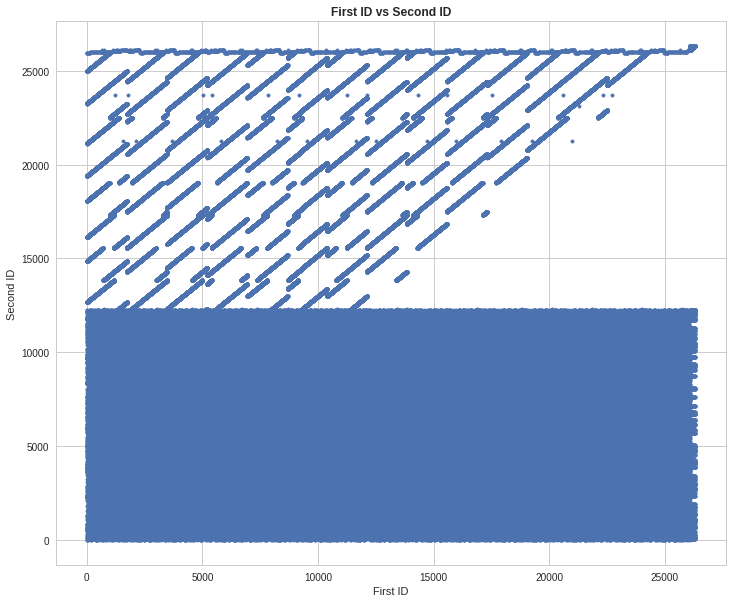

In [20]:
figure, axe = pyplot.subplots(figsize=FIGURE_SIZE)
axe.set_title("First ID vs Second ID", weight="bold")
axe.set_xlabel("First ID")
axe.set_ylabel("Second ID")
plot = pyplot.scatter(test.FirstId, test.SecondId, marker='.')

# Building a magic feature

In this section we will build a magic feature, that will solve the problem almost perfectly. The instructions will lead you to the correct solution, but please, try to explain the purpose of the steps we do to yourself -- it is very important.

## Incidence matrix

First, we need to build an [incidence matrix](https://en.wikipedia.org/wiki/Incidence_matrix). You can think of pairs `(FirstId, SecondId)` as of edges in an undirected graph. 

The incidence matrix is a matrix of size `(maxId + 1, maxId + 1)`, where each row (column) `i` corresponds `i-th` `Id`. In this matrix we put the value `1` to the position `[i, j]`, if and only if a pair `(i, j)` or `(j, i)` is present in  a given set of pais `(FirstId, SecondId)`. All the other elements in the incidence matrix are zeros.   

**Important!** The incidence matrices are typically very very sparse (small number of non-zero values). At the same time incidence matrices are usually huge in terms of total number of elements, and it is **impossible to store them in memory in dense format**. But due to their sparsity incidence matrices **can be easily represented as sparse matrices**. If you are not familiar with sparse matrices, please see [wiki](https://en.wikipedia.org/wiki/Sparse_matrix) and [scipy.sparse reference](https://docs.scipy.org/doc/scipy/reference/sparse.html). Please, use any of `scipy.sparse` constructors to build incidence matrix. 

For example, you can use this constructor: `scipy.sparse.coo_matrix((data, (i, j)))`. We highly recommend to learn to use different `scipy.sparse` constuctors, and matrices types, but if you feel you don't want to use them, you can always build this matrix with a simple `for` loop. You will need first to create a matrix using `scipy.sparse.coo_matrix((M, N), [dtype])` with an appropriate shape `(M, N)` and then iterate through `(FirstId, SecondId)` pairs and fill corresponding elements in matrix with ones. 

**Note**, that the matrix should be symmetric and consist only of zeros and ones. It is a way to check yourself.

In [9]:
# Edges in an undirected graph
pairs = np.unique(np.concatenate([test[['FirstId', 'SecondId']].values, test[['SecondId', 'FirstId']].values]), axis=0)

inc_mat = scipy.sparse.coo_matrix((np.ones(len(pairs)), (pairs[:, 0], pairs[:, 1]))) # YOUR CODE GOES HERE


# Sanity checks
assert inc_mat.max() == 1
assert inc_mat.sum() == 736872

It is convenient to have matrix in `csr` format eventually.

In [10]:
inc_mat = inc_mat.tocsr()

## Now build the magic feature

Why did we build the incidence matrix? We can think of the rows in this matix as of representations for the objects. `i-th` row is a representation for an object with `Id = i`. Then, to measure similarity between two objects we can measure similarity between their representations. And we will see, that such representations are very good.

Now select the rows from the incidence matrix, that correspond to `test.FirstId`'s, and `test.SecondId`'s.

In [11]:
# Note, scipy goes crazy if a matrix is indexed with pandas' series. 
# So do not forget to convert `pd.series` to `np.array`
# These lines should normally run very quickly 

rows_FirstId   = inc_mat[test['FirstId'].values] # YOUR CODE GOES HERE
rows_SecondId  = inc_mat[test['SecondId'].values] # YOUR CODE GOES HERE

Our magic feature will be the *dot product* between representations of a pair of objects. Dot product can be regarded as similarity measure -- for our non-negative representations the dot product is close to 0 when the representations are different, and is huge, when representations are similar. 

Now compute dot product between corresponding rows in `rows_FirstId` and `rows_SecondId` matrices.

In [25]:
# Note, that in order to do pointwise multiplication in scipy.sparse you need to use function `multiply`
# regular `*` corresponds to matrix-matrix multiplication
pointwise_mult = rows_FirstId.multiply(rows_SecondId)
f = np.squeeze(np.asarray(pointwise_mult.sum(axis=1))) # YOUR CODE GOES HERE

# Sanity check
assert f.shape == (368550, )

That is it! **We've built our magic feature.** 

# From magic feature to binary predictions

But how do we convert this feature into binary predictions? We do not have a train set to learn a model, but we have a piece of information about test set: the baseline accuracy score that you got, when submitting constant. And we also have a very strong considerations about the data generative process, so probably we will be fine even without a training set. 

We may try to choose a thresold, and set the predictions to 1, if the feature value `f` is higer than the threshold, and 0 otherwise. What threshold would you choose? 

How do we find a right threshold? Let's first examine this feature: print frequencies (or counts) of each value in the feature `f`.

In [29]:
# For example use `np.unique` function, check for flags
ret, counts = np.unique(f, return_counts=True)
#print(ret) # YOUR CODE GOES HERE
print (np.asarray((ret, counts)).T)

[[  1.40000000e+01   1.83279000e+05]
 [  1.50000000e+01   8.52000000e+02]
 [  1.90000000e+01   5.46000000e+02]
 [  2.00000000e+01   1.83799000e+05]
 [  2.10000000e+01   6.00000000e+00]
 [  2.80000000e+01   5.40000000e+01]
 [  3.50000000e+01   1.40000000e+01]]


Do you see how this feature clusters the pairs? Maybe you can guess a good threshold by looking at the values? 

In fact, in other situations it can be not that obvious, but in general to pick a threshold you only need to remember the score of your baseline submission and use this information. Do you understand why and how?  

Choose a threshold below: 

In [30]:
pred = f > 19 # SET THRESHOLD HERE

* In a large data set 368550 the number of unique pairs is quite small about 26325. We assumed that the total number of ID pairs classified as 1 is small compared to total pairs possible.
* Created a dataframe with PairId and prediction that have a class of 1. Got an accuracy of 0.5
* This means that the test set is constructed not by sampling random pairs, but with a specific sampling algorithm which caused the pairs of class 1 to be oversampled.
* Constructing the incidence matrix showed that half the vectors about 183799000 had a similarity of 20 (greater than 19) or more. 
* By predicting that all paris whose incidence matrix dot product were greater than or equal 20 were of the same class we were able to predict with greater than. 99.8% accuracy which IDs were of the same class.

# Finally, let's create a submission

In [15]:
submission = test.loc[:,['pairId']]
submission['Prediction'] = pred.astype(int)

submission.to_csv('submission.csv', index=False)

In [ ]:
Uploading all the submissions as one (so all the ID-pairs were classified as having IDs from the same class)
we saw that half the entries were 1's and half were 0's. 
Our incidence matrix showed that half the vectors had a similarity of 20 or more, 
so by predicting that all the pairs whose incidence matrix dot-products were 20 or greater were of the same class, 
we could predict with greater than 99% accuracy which IDs were from the same class.

Now submit it to the grader! It is not possible to submit directly from this notebook, as we need to submit a `csv` file, not a single number (limitation of Coursera platform). 

To download `submission.csv` file that you've just produced <a href='./submission.csv'>click here</a> (if the link opens in browser, right-click on it and shoose "Save link as"). Then go to [assignment page](https://www.coursera.org/learn/competitive-data-science/programming/KsASv/data-leakages/submission) and submit your `.csv` file in 'My submission' tab.


If you did everything right, the score should be very high.

**Finally:** try to explain to yourself, why the whole thing worked out. In fact, there is no magic in this feature, and the idea to use rows in the incidence matrix can be intuitively justified.

# Bonus

Interestingly, it is not the only leak in this dataset. There is another totally different way to get almost 100% accuracy. Try to find it!